![Quora-1.png](attachment:Quora-1.png)

<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

In [1]:
!pip install fuzzywuzzy
!pip install distance

     |████████████████████████████████| 184kB 9.9MB/s 
  Created wheel for distance: filename=Distance-0.1.3-cp37-none-any.whl size=16261 sha256=acdcc722d61fbe99ce2abc66751ccbf47460b718ef9c92aadfa2aee380d6b6dd
  Stored in directory: /root/.cache/pip/wheels/d5/aa/e1/dbba9e7b6d397d645d0f12db1c66dbae9c5442b39b001db18e
Successfully built distance


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
from sklearn.manifold import TSNE
import plotly.graph_objs as go
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
import plotly.tools as tls
import os
import gc
import tqdm.notebook as tq
from sklearn.metrics import confusion_matrix
import math
import re
import pickle
from fuzzywuzzy import fuzz
from sklearn.metrics.classification import accuracy_score, log_loss
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lxgb
import warnings
warnings.filterwarnings('ignore')
import nltk

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



<h2> 3.1 Reading data and basic stats </h2>

In [5]:
df = pd.read_csv("train.csv")


In [6]:
# shape of the data 

df.shape

(404290, 6)

In [7]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [8]:
# dataFrame consists of 6 columns 1-row ID, 2-1st Question ID, 3-2nd Question ID, 4-Question1, 5-Question2, 6-TargetVariable defining whether both questions are similar or not 

Distribution of Target Class ( total number of similar and dissimilar pairs )

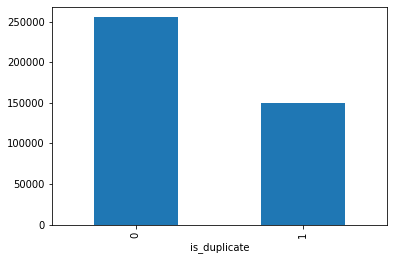

In [9]:
val = df.groupby("is_duplicate").count()["id"].plot.bar()


Dataset is little imbalanced

In [10]:
print(" Total number of pairs available = {}".format(len(df)))

 Total number of pairs available = 404290


In [11]:
print(" Percentage of similar question = {}".format((len(df[df["is_duplicate"]==1])/len(df))*100))
print(" PErcentage of dissimilar questnios = {}".format((len(df[df["is_duplicate"]==0])/len(df))*100))

 Percentage of similar question = 36.9197853026293
 PErcentage of dissimilar questnios = 63.08021469737069


<h3> 3.2.2 Number of unique questions </h3>

In [12]:
total_questions = pd.Series(df["qid1"].tolist()+df["qid2"].tolist())

In [13]:
unique_questions = len(np.unique(total_questions))

In [14]:
unique_questions       # total number of unique questions 

537933

In [15]:
repeated_questions = np.sum(total_questions.value_counts()>1)
repeated_questions

111780

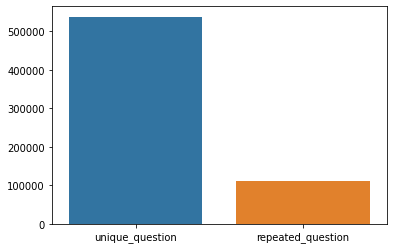

In [16]:
sns.barplot(["unique_question","repeated_question"],[unique_questions,repeated_questions])
plt.show()

<h3>3.2.3 Checking for Duplicates question pairs  </h3>

In [17]:
df.groupby(["qid1","qid2"]).count().shape[0] - df.shape[0]

0

There are no Duplicate rows 

<h3> 3.2.4 Number of occurrences of each question </h3>

In [18]:
total_questions = pd.Series(df["qid1"].tolist()+df["qid2"].tolist())

question_occurances = total_questions.value_counts()

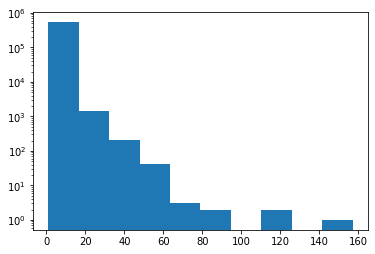

 question that appeared max number of times 157


In [19]:
plt.yscale('log')
plt.hist(question_occurances)
plt.show()
print(" question that appeared max number of times {}".format(max(total_questions.value_counts())))

The Number of questions occuring once is more and question that appeared max number of times is 157

<h3> 3.2.5 Checking for NULL values </h3>

In [20]:
#Checking whether there are any rows with null values
df.isnull().values.any()


True

There are null values present 

In [21]:
df[df.isnull().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


3 rows have null values present 

In [22]:
df = df.fillna(" ")
df[df.isnull().any(1)] 

,id,qid1,qid2,question1,question2,is_duplicate


Splitting the data 

In [23]:
y = df["is_duplicate"]
x = df.drop("is_duplicate",axis=1)

In [24]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,stratify=y,random_state=19)

In [25]:
x_train.shape

(323432, 5)

In [26]:
x_test.shape

(80858, 5)

<h2>3.3 Basic Feature Extraction </h2>

1. Frequency of the questions

In [27]:
x_train["frequency_of_qid1"] = x_train.groupby("qid1")["qid1"].transform('count')
x_train["frequency_of_qid2"] = x_train.groupby("qid2")["qid2"].transform('count')
x_test["frequency_of_qid1"] = x_test.groupby("qid1")["qid1"].transform('count')
x_test["frequency_of_qid2"] = x_test.groupby("qid2")["qid2"].transform('count')

2. length of questions

In [28]:
x_train.head()

,id,qid1,qid2,question1,question2,frequency_of_qid1,frequency_of_qid2
124074,124074,3595,134237,How do i lose weight?,What is the ideal way of loosing weight?,35,3
65272,65272,109767,113306,"What words are similar to ""cool"" or ""awesome"" ...",What are some French words that start with W?,2,1
261118,261118,377186,131902,What are some best psychological thriller movies?,Which are the best brain twisting psychologica...,1,4
214044,214044,153998,34123,How do I tell if she likes me?,How do I know that she like me?,2,8
402320,402320,288877,535787,If I want a good job with a good salary after ...,I chose job for industrial exp after completin...,2,1


2. Question length 

In [29]:
x_train["q1_length"] = x_train["question1"].str.len()
x_train["q2_length"] = x_train["question2"].str.len()
x_test["q1_length"] = x_test["question1"].str.len()
x_test["q2_length"] = x_test["question2"].str.len()

In [30]:
x_train.head()

,id,qid1,qid2,question1,question2,frequency_of_qid1,frequency_of_qid2,q1_length,q2_length
124074,124074,3595,134237,How do i lose weight?,What is the ideal way of loosing weight?,35,3,21,40
65272,65272,109767,113306,"What words are similar to ""cool"" or ""awesome"" ...",What are some French words that start with W?,2,1,56,45
261118,261118,377186,131902,What are some best psychological thriller movies?,Which are the best brain twisting psychologica...,1,4,49,74
214044,214044,153998,34123,How do I tell if she likes me?,How do I know that she like me?,2,8,30,31
402320,402320,288877,535787,If I want a good job with a good salary after ...,I chose job for industrial exp after completin...,2,1,88,148


3. Number of words in question1 and question2 

In [31]:
x_train["q1_num_words"] = x_train["question1"].apply(lambda row: len(row.split(" ")))
x_train["q2_num_words"] = x_train["question2"].apply(lambda row: len(row.split(" ")))
x_test["q1_num_words"] = x_test["question1"].apply(lambda row: len(row.split(" ")))
x_test["q2_num_words"] = x_test["question2"].apply(lambda row: len(row.split(" ")))

In [32]:
x_train.head()

,id,qid1,qid2,question1,question2,frequency_of_qid1,frequency_of_qid2,q1_length,q2_length,q1_num_words,q2_num_words
124074,124074,3595,134237,How do i lose weight?,What is the ideal way of loosing weight?,35,3,21,40,5,8
65272,65272,109767,113306,"What words are similar to ""cool"" or ""awesome"" ...",What are some French words that start with W?,2,1,56,45,10,9
261118,261118,377186,131902,What are some best psychological thriller movies?,Which are the best brain twisting psychologica...,1,4,49,74,7,11
214044,214044,153998,34123,How do I tell if she likes me?,How do I know that she like me?,2,8,30,31,8,8
402320,402320,288877,535787,If I want a good job with a good salary after ...,I chose job for industrial exp after completin...,2,1,88,148,19,26


4. number of common words in both questions 

In [33]:
def word_common(row):
  w1 = set(map(lambda word: word.lower().strip(),row["question1"].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(),row["question2"].split(" ")))
  return 1*len(w1 & w2)
x_train["word_common"] = x_train.apply(word_common,axis=1)
x_test["word_common"] = x_test.apply(word_common,axis=1)


5. total word count

In [34]:
def total_word(row):
  w1 = set(map(lambda word: word.lower().strip(),row["question1"].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(),row["question2"].split(" ")))
  return 1* len(w1)+len(w2)

x_train["total_count"] = x_train.apply(total_word,axis=1)
x_test["total_count"] = x_test.apply(total_word,axis=1)

In [35]:
x_train.head()

,id,qid1,qid2,question1,question2,frequency_of_qid1,frequency_of_qid2,q1_length,q2_length,q1_num_words,q2_num_words,word_common,total_count
124074,124074,3595,134237,How do i lose weight?,What is the ideal way of loosing weight?,35,3,21,40,5,8,1,13
65272,65272,109767,113306,"What words are similar to ""cool"" or ""awesome"" ...",What are some French words that start with W?,2,1,56,45,10,9,3,19
261118,261118,377186,131902,What are some best psychological thriller movies?,Which are the best brain twisting psychologica...,1,4,49,74,7,11,4,18
214044,214044,153998,34123,How do I tell if she likes me?,How do I know that she like me?,2,8,30,31,8,8,5,16
402320,402320,288877,535787,If I want a good job with a good salary after ...,I chose job for industrial exp after completin...,2,1,88,148,19,26,8,39


6. Word share  ( common / total)

In [36]:
def word_share(row):
  w1 = set(map(lambda word: word.lower().strip(),row["question1"].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(),row["question2"].split(" ")))
  return 1* (len(w1 & w2)/(len(w1)+len(w2)))
x_train["word_share"] = x_train.apply(word_share,axis=1)  
x_test["word_share"] = x_test.apply(word_share,axis=1)  

In [37]:
x_train.head()

,id,qid1,qid2,question1,question2,frequency_of_qid1,frequency_of_qid2,q1_length,q2_length,q1_num_words,q2_num_words,word_common,total_count,word_share
124074,124074,3595,134237,How do i lose weight?,What is the ideal way of loosing weight?,35,3,21,40,5,8,1,13,0.076923
65272,65272,109767,113306,"What words are similar to ""cool"" or ""awesome"" ...",What are some French words that start with W?,2,1,56,45,10,9,3,19,0.157895
261118,261118,377186,131902,What are some best psychological thriller movies?,Which are the best brain twisting psychologica...,1,4,49,74,7,11,4,18,0.222222
214044,214044,153998,34123,How do I tell if she likes me?,How do I know that she like me?,2,8,30,31,8,8,5,16,0.312500
402320,402320,288877,535787,If I want a good job with a good salary after ...,I chose job for industrial exp after completin...,2,1,88,148,19,26,8,39,0.205128


7. sum and difference of frequency 

In [38]:
x_train["frequency_sum"] = x_train["frequency_of_qid1"] + x_train["frequency_of_qid2"]
x_train["frequency_sub"] = x_train["frequency_of_qid1"] - x_train["frequency_of_qid2"]
x_test["frequency_sum"] = x_test["frequency_of_qid1"] + x_test["frequency_of_qid2"]
x_test["frequency_sub"] = x_test["frequency_of_qid1"] - x_test["frequency_of_qid2"]

In [39]:
x_train.head()

,id,qid1,qid2,question1,question2,frequency_of_qid1,frequency_of_qid2,q1_length,q2_length,q1_num_words,q2_num_words,word_common,total_count,word_share,frequency_sum,frequency_sub
124074,124074,3595,134237,How do i lose weight?,What is the ideal way of loosing weight?,35,3,21,40,5,8,1,13,0.076923,38,32
65272,65272,109767,113306,"What words are similar to ""cool"" or ""awesome"" ...",What are some French words that start with W?,2,1,56,45,10,9,3,19,0.157895,3,1
261118,261118,377186,131902,What are some best psychological thriller movies?,Which are the best brain twisting psychologica...,1,4,49,74,7,11,4,18,0.222222,5,-3
214044,214044,153998,34123,How do I tell if she likes me?,How do I know that she like me?,2,8,30,31,8,8,5,16,0.312500,10,-6
402320,402320,288877,535787,If I want a good job with a good salary after ...,I chose job for industrial exp after completin...,2,1,88,148,19,26,8,39,0.205128,3,1


Violin plot for wordshare feature , to check whether it adds value in classfication task

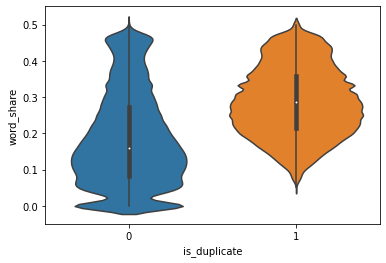

In [40]:
df["word_share"] = x_train["word_share"]

sns.violinplot(x="is_duplicate", y="word_share",data=df)

we can see that the mean of both classes are not similar,and also the distribution of the classes differ a bit, from which we conclude it adds a small value in classification 

pdf for word_share

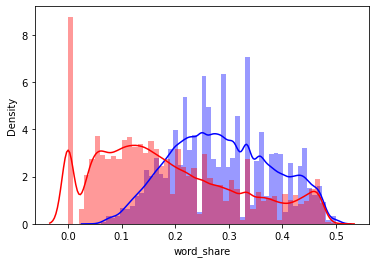

In [41]:
sns.distplot(df[df["is_duplicate"]==1]["word_share"],color='blue')
sns.distplot(df[df["is_duplicate"]==0]["word_share"],color='red')

from this also we can infer that word_share column adds some value for our task 

### PreProcessing

Removing HTML Tags,
Stemming

In [42]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [43]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')          # pattern that is not letter,digit or underscore
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)            # removing the HTML tags 
        x = example1.get_text()
               
    
    return x
    

In [44]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset

    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [45]:
x_train = extract_features(x_train)
x_test = extract_features(x_test)

token features...
fuzzy features..
token features...
fuzzy features..


In [46]:
x_train.head()

,id,qid1,qid2,question1,question2,frequency_of_qid1,frequency_of_qid2,q1_length,q2_length,q1_num_words,q2_num_words,word_common,total_count,word_share,frequency_sum,frequency_sub,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
124074,124074,3595,134237,how do i lose weight,what is the ideal way of loosing weight,35,3,21,40,5,8,1,13,0.076923,38,32,0.499975,0.249994,0.000000,0.000000,0.199996,0.124998,1.0,0.0,3.0,6.5,51,51,47,62,0.363636
65272,65272,109767,113306,what words are similar to cool or awesome ...,what are some french words that start with w,2,1,56,45,10,9,3,19,0.157895,3,1,0.499988,0.399992,0.399992,0.399992,0.444440,0.399996,0.0,1.0,1.0,9.5,67,61,34,45,0.173913
261118,261118,377186,131902,what are some best psychological thriller movies,which are the best brain twisting psychologica...,1,4,49,74,7,11,4,18,0.222222,5,-3,0.999975,0.499994,0.333322,0.333322,0.714276,0.454541,0.0,0.0,4.0,9.0,88,71,71,69,0.620000
214044,214044,153998,34123,how do i tell if she likes me,how do i know that she like me,2,8,30,31,8,8,5,16,0.312500,10,-6,0.000000,0.000000,0.833319,0.833319,0.624992,0.624992,1.0,1.0,0.0,8.0,78,78,75,73,0.290323
402320,402320,288877,535787,if i want a good job with a good salary after ...,i chose job for industrial exp after completin...,2,1,88,148,19,26,8,39,0.205128,3,1,0.571420,0.266665,0.499994,0.444440,0.421050,0.307691,0.0,0.0,7.0,22.5,71,54,38,47,0.202247


In [47]:
x_test.head()

,id,qid1,qid2,question1,question2,frequency_of_qid1,frequency_of_qid2,q1_length,q2_length,q1_num_words,q2_num_words,word_common,total_count,word_share,frequency_sum,frequency_sub,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
194591,194591,294846,103057,what happens when i archive a conversation on ...,what is with the archived chats on whatsapp,1,1,55,43,9,7,2,16,0.125000,2,0,0.333322,0.249994,0.399992,0.399992,0.374995,0.333330,1.0,1.0,1.0,8.5,70,70,70,68,0.288889
317438,317438,442632,442633,is the science of urine underrated,what would you do if you were fired from googl...,1,1,35,57,6,11,0,16,0.000000,2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,5.0,8.5,14,13,13,26,0.083333
373489,373489,504302,68326,is lucid dreaming scary,is lucid dreaming real,1,1,24,23,4,4,3,8,0.375000,2,0,0.666644,0.666644,0.999900,0.999900,0.749981,0.749981,0.0,1.0,0.0,4.0,87,84,84,83,0.750000
356385,356385,485697,82391,how is the life of indians who settle abroad ...,how is the life of indians who settle abroad ...,1,1,88,89,16,17,15,33,0.454545,2,0,0.999990,0.999990,0.999983,0.999983,0.999994,0.999994,1.0,1.0,0.0,16.0,100,100,100,100,0.988764
326181,326181,452452,452453,can women get horny for men,do women get horny as often and as intensely a...,1,1,28,52,6,11,4,15,0.266667,2,0,0.999975,0.666656,0.000000,0.000000,0.666656,0.363633,1.0,0.0,5.0,8.5,83,62,56,75,0.586207


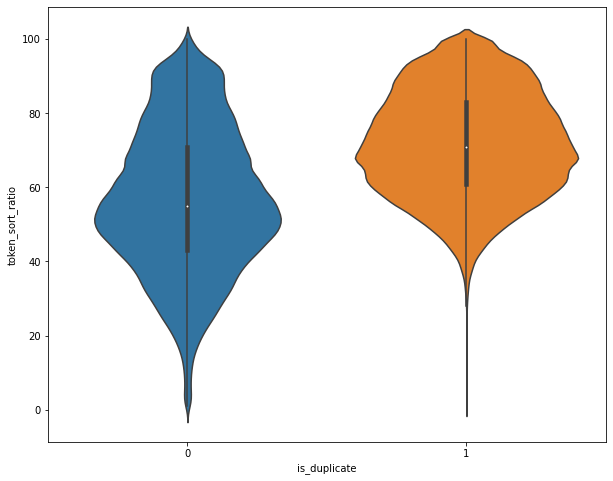

In [48]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

sns.violinplot(x = y_train, y = 'token_sort_ratio', data = x_train[0:]  )

plt.show()

## Pair PLot

In [49]:
n = x_train.shape[0]
data = x_train[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']][0:n]
data["is_duplicate"] = y_train

In [50]:
data.head()

,ctc_min,cwc_min,csc_min,token_sort_ratio,is_duplicate
124074,0.199996,0.499975,0.000000,51,1
65272,0.444440,0.499988,0.399992,61,0
261118,0.714276,0.999975,0.333322,71,1
214044,0.624992,0.000000,0.833319,78,1
402320,0.421050,0.571420,0.499994,54,0


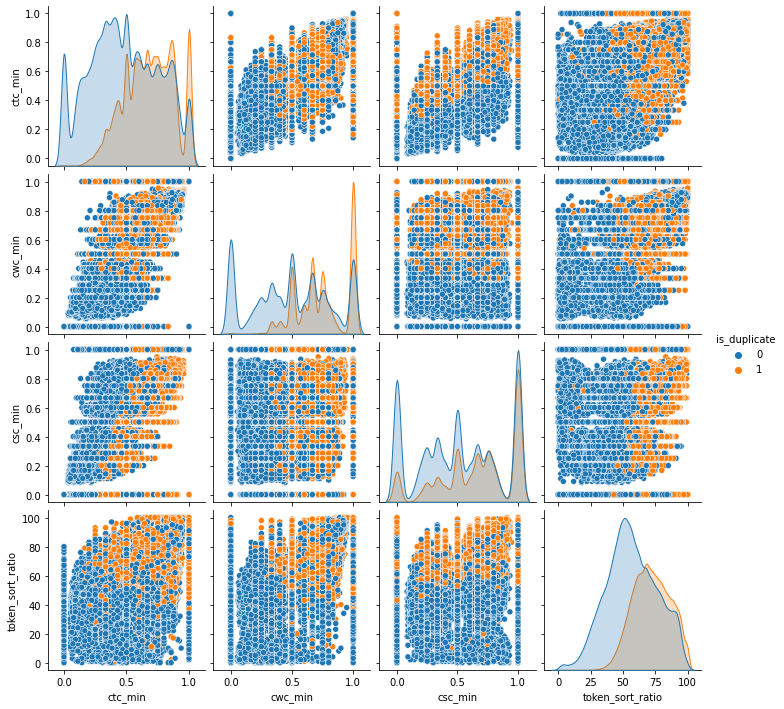

In [51]:
sns.pairplot(data, hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

In [52]:
# Feature Considere : 'cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio'

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = x_train[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = y_train[:5000].values

In [53]:
tsne2d = TSNE(
    n_components=2,
    init='pca', # pca
    random_state=101,
    n_iter=1000,
    verbose=2,
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.017s...
[t-SNE] Computed neighbors for 5000 samples in 0.446s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.139534
[t-SNE] Computed conditional probabilities in 0.312s
[t-SNE] Iteration 50: error = 70.6903687, gradient norm = 0.0112884 (50 iterations in 2.095s)
[t-SNE] Iteration 100: error = 68.9761505, gradient norm = 0.0051092 (50 iterations in 1.869s)
[t-SNE] Iteration 150: error = 68.2652283, gradient norm = 0.0039255 (50 iterations in 1.878s)
[t-SNE] Iteration 200: error = 67.8448944, gradient norm = 0.0031381 (50 iterations in 1.865s)
[t-SNE] Iteration 250: error = 67.5448456, gradient norm = 0.0028359

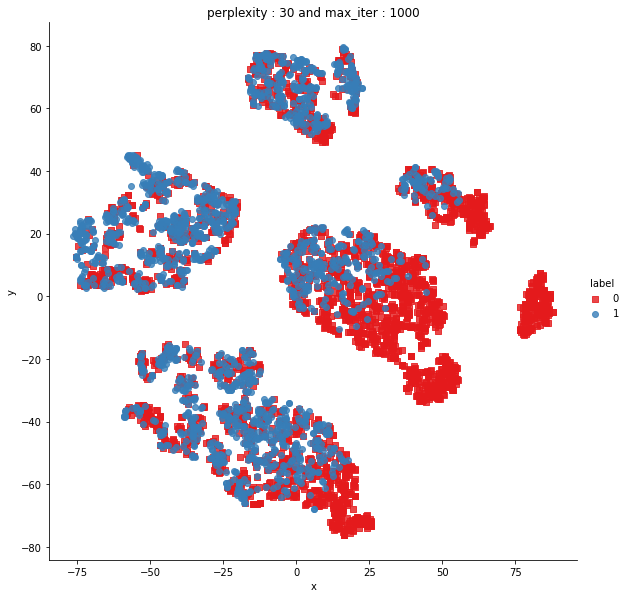

In [ ]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

## We can infer from the visualization that features added newly help in classifaction task


### TF-IDF W2V representation of questions

In [54]:
!unzip "/content/archive.zip" -d "/content/sample_data"

Archive:  /content/archive.zip
  inflating: /content/sample_data/glove.6B.100d.txt  


In [55]:
embeddings_dict = {}
with open("/content/sample_data/glove.6B.100d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [56]:
questions_train = list(x_train['question1']) + list(x_train['question2'])

In [57]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer(lowercase=False,)
tfidf_model.fit(questions_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [58]:
tfidf_w2v_vectors = []; 
for sentence in tq.tqdm(x_train["question1"]):                   # for each review/sentence
    vector = np.zeros(100)                                       # as word vectors are of zero length
    tf_idf_weight =0;                                        
    for word in sentence.split():                                # for each word in a review/sentence
        if (word in embeddings_dict) and (word in tfidf_words):
            vec = embeddings_dict[word]                                    # getting the vector for each word
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))                   # getting the tfidf value for each word
            vector += (vec * tf_idf)                                                                 # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)


In [59]:
tfidf_w2v_vectors_2 = []; 
for sentence in tq.tqdm(x_train["question2"]):                   # for each review/sentence
    vector = np.zeros(100)                                       # as word vectors are of zero length
    tf_idf_weight =0;                                        
    for word in sentence.split():                                # for each word in a review/sentence
        if (word in embeddings_dict) and (word in tfidf_words):
            vec = embeddings_dict[word]                                    # getting the vector for each word
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))                   # getting the tfidf value for each word
            vector += (vec * tf_idf)                                                                 # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_2.append(vector)


In [60]:
X_train_q1 = pd.DataFrame(tfidf_w2v_vectors, index= x_train.index)


In [61]:
X_train_q2 = pd.DataFrame(tfidf_w2v_vectors_2, index= x_train.index)

In [62]:
X_train_q1['id']=x_train['id']
X_train_q2['id']=x_train['id']
df1  = X_train_q1.merge(X_train_q2, on='id',how='left')
x_train  = x_train.merge(df1, on='id',how='left')

In [63]:
x_train.head()

,id,qid1,qid2,question1,question2,frequency_of_qid1,frequency_of_qid2,q1_length,q2_length,q1_num_words,q2_num_words,word_common,total_count,word_share,frequency_sum,frequency_sub,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y,96_y,97_y,98_y,99_y
0,124074,3595,134237,how do i lose weight,what is the ideal way of loosing weight,35,3,21,40,5,8,1,13,0.076923,38,32,0.499975,0.249994,0.000000,0.000000,0.199996,0.124998,1.0,0.0,3.0,6.5,51,51,47,62,0.363636,0.085260,0.474849,0.385856,-0.186305,-0.961617,0.017779,-0.401412,0.130622,-0.087864,...,0.034496,0.384607,-0.110673,0.286081,0.562152,0.232749,0.283746,-0.141107,0.146476,-0.429400,-0.128455,-0.207002,0.144297,-0.005964,0.060475,-0.071759,-0.088989,-0.322382,-0.418740,0.050796,0.021714,0.098654,-0.584027,0.088673,-0.581942,-0.018589,0.151111,-0.061213,-0.249293,-0.365309,-0.208624,0.109586,0.305751,0.070999,-0.079676,-0.385755,-0.221660,-0.345236,0.393141,0.627333
1,65272,109767,113306,what words are similar to cool or awesome ...,what are some french words that start with w,2,1,56,45,10,9,3,19,0.157895,3,1,0.499988,0.399992,0.399992,0.399992,0.444440,0.399996,0.0,1.0,1.0,9.5,67,61,34,45,0.173913,-0.158835,0.221080,0.309946,-0.160231,-0.193373,0.390470,-0.030055,-0.005601,-0.137052,...,0.083288,0.891406,-0.158978,-0.116775,0.648494,0.007868,0.364745,0.416680,0.065543,-0.394033,-0.145691,-0.050180,-0.228896,-0.578162,0.200417,0.291239,0.064798,0.254287,-0.983165,-0.043000,0.770723,-0.495520,-0.497294,0.086302,-1.514471,-0.258859,0.084997,-0.093491,-0.158869,-0.527407,-0.149474,-0.054766,-0.201562,0.182191,-0.666104,-0.052762,-0.611105,-0.393269,0.419340,0.372640
2,261118,377186,131902,what are some best psychological thriller movies,which are the best brain twisting psychologica...,1,4,49,74,7,11,4,18,0.222222,5,-3,0.999975,0.499994,0.333322,0.333322,0.714276,0.454541,0.0,0.0,4.0,9.0,88,71,71,69,0.620000,0.060076,0.195545,0.359410,-0.229983,-0.030830,0.195456,-0.293327,-0.375137,-0.326413,...,0.081285,1.078343,-0.030882,-0.063981,0.439287,-0.049268,0.203498,0.203108,-0.030285,-0.121892,0.007308,0.014005,0.066398,0.207153,-0.183137,-0.018037,-0.128128,0.153100,-0.239289,0.083756,0.219693,0.337850,-0.322414,0.192019,-1.416297,0.081269,-0.055038,0.041435,-0.225062,-0.267778,-0.273785,0.009300,-0.170077,0.050355,0.058639,0.067769,0.121072,-0.713627,0.441220,0.117854
3,214044,153998,34123,how do i tell if she likes me,how do i know that she like me,2,8,30,31,8,8,5,16,0.312500,10,-6,0.000000,0.000000,0.833319,0.833319,0.624992,0.624992,1.0,1.0,0.0,8.0,78,78,75,73,0.290323,-0.079063,0.349173,0.507965,-0.348520,-0.470519,0.361819,-0.370060,0.255086,0.248557,...,-0.031457,1.233823,-0.398775,-0.115821,0.845264,0.150044,0.958742,0.530356,-0.028868,0.005416,0.173686,-0.251449,0.009777,-0.406278,0.195508,0.298455,0.064110,-0.278289,-0.678167,-0.107400,0.602557,-0.257146,-0.625991,0.040033,-1.805213,-0.500555,-0.083314,-0.180283,-0.626743,-0.560300,0.033101,-0.395401,0.260836,-0.069472,-0.449651,-0.036634,-0.407436,-0.328016,0.210051,0.564130
4,402320,288877,535787,if i want a good job with a good salary after ...,i chose job for industrial exp after completin...,2,1,88,148,19,26,8,39,0.205128,3,1,0.571420,0.266665,0.499994,0.444440,0.421050,0.307691,0.0,0.0,7.0,22.5,71,54,38,47,0.202247,-0.028516,0.201708,0.326871,-0.190899,-0.542020,-0.078225,0.031148,0.123903,-0.334728,...,-0.308125,0.392757,-0.324477,-0.016620,0.483391,0.160822,0.195490,0.230925,0.260651,-0.069521,0.017037,-0.150937,-0.329579,-0.278108,-0.012021,0.075569,-0.249131,-0.097974,-0.521388,-0.118554,0.500026,0.078943,-0.375805,0.051233,-1.007233,-0.026282,0.106981,-0.303811,-0.234931

In [64]:
questions_test = list(x_test['question1']) + list(x_test['question2']) 

In [65]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer(lowercase=False,)
tfidf_model.fit(questions_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [66]:
tfidf_w2v_vectors = []; 
for sentence in tq.tqdm(x_test["question1"]):                   # for each review/sentence
    vector = np.zeros(100)                                       # as word vectors are of zero length
    tf_idf_weight =0;                                        
    for word in sentence.split():                                # for each word in a review/sentence
        if (word in embeddings_dict) and (word in tfidf_words):
            vec = embeddings_dict[word]                                    # getting the vector for each word
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))                   # getting the tfidf value for each word
            vector += (vec * tf_idf)                                                                 # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)


In [67]:
tfidf_w2v_vectors_2 = []; 
for sentence in tq.tqdm(x_test["question2"]):                   # for each review/sentence
    vector = np.zeros(100)                                       # as word vectors are of zero length
    tf_idf_weight =0;                                        
    for word in sentence.split():                                # for each word in a review/sentence
        if (word in embeddings_dict) and (word in tfidf_words):
            vec = embeddings_dict[word]                                    # getting the vector for each word
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))                   # getting the tfidf value for each word
            vector += (vec * tf_idf)                                                                 # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_2.append(vector)


In [68]:
X_test_q1 = pd.DataFrame(tfidf_w2v_vectors, index= x_test.index)


In [69]:
X_test_q2 = pd.DataFrame(tfidf_w2v_vectors_2, index= x_test.index)

In [70]:
X_test_q1['id']=x_test['id']
X_test_q2['id']=x_test['id']
df1  = X_test_q1.merge(X_test_q2, on='id',how='left')
x_test  = x_test.merge(df1, on='id',how='left')

In [71]:
x_train.drop(["id","qid1","qid2","question1","question2"],axis=1,inplace=True)

In [72]:
x_test.drop(["id","qid1","qid2","question1","question2"],axis=1,inplace=True)

In [73]:
x_train.shape

(323432, 226)

In [74]:
x_test.shape

(80858, 226)

# Applying Models 

In [75]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

### Random model 

Log loss on Test Data using Random Model 0.8880971181320815


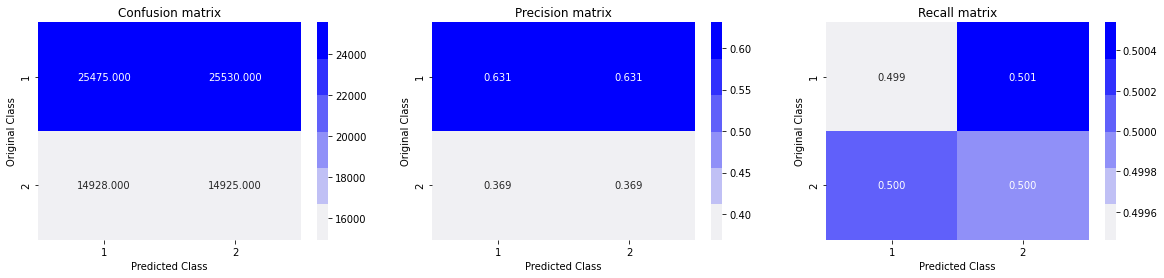

In [76]:
predicted_y = np.zeros((len(y_test),2))
for i in range(len(y_test)):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))
predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

Random model has a loss of 0.8899038722287334 



#Logistic Regression

In [77]:
alpha = [10 ** x for x in range(-3, 2)] 
log_error_array_LR=[] 
for i in alpha: 
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42) 
    clf.fit(x_train, y_train) 
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid") 
    sig_clf.fit(x_train, y_train) 
    predict_y = sig_clf.predict_proba(x_test)
    log_error_array_LR.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  0.001 The log loss is: 0.5285743960512319
For values of alpha =  0.01 The log loss is: 0.49746502459760755
For values of alpha =  0.1 The log loss is: 0.525222934327049
For values of alpha =  1 The log loss is: 0.5563983431899342
For values of alpha =  10 The log loss is: 0.5844587980859829


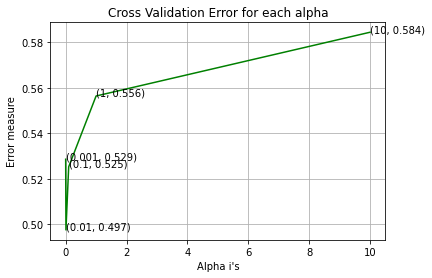

In [78]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array_LR,c='g')
for i, txt in enumerate(np.round(log_error_array_LR,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array_LR[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


For values of best alpha =  0.01 The train log loss is: 0.4544360980119401
For values of best alpha =  0.01 The test log loss is: 0.49746502459760755
Total number of data points : 80858


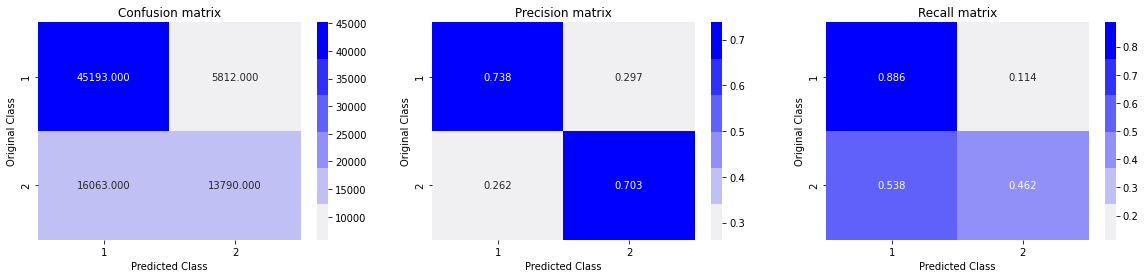

In [79]:
best_alpha = np.argmin(log_error_array_LR)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)

predict_y = sig_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)  

# Linear SVM

In [80]:
alpha = [10 ** x for x in range(-3, 2)]
log_error_array_SVM=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_test)
    log_error_array_SVM.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  0.001 The log loss is: 0.5149498488341023
For values of alpha =  0.01 The log loss is: 0.5113145256567305
For values of alpha =  0.1 The log loss is: 0.5486016371165755
For values of alpha =  1 The log loss is: 0.6310471430874707
For values of alpha =  10 The log loss is: 0.619763129053723


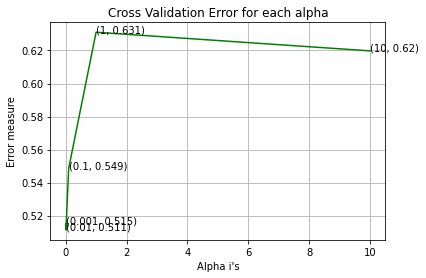

In [81]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array_SVM,c='g')
for i, txt in enumerate(np.round(log_error_array_SVM,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array_SVM[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  0.01 The train log loss is: 0.4649537029841692
For values of best alpha =  0.01 The test log loss is: 0.5113145256567305
Total number of data points : 80858


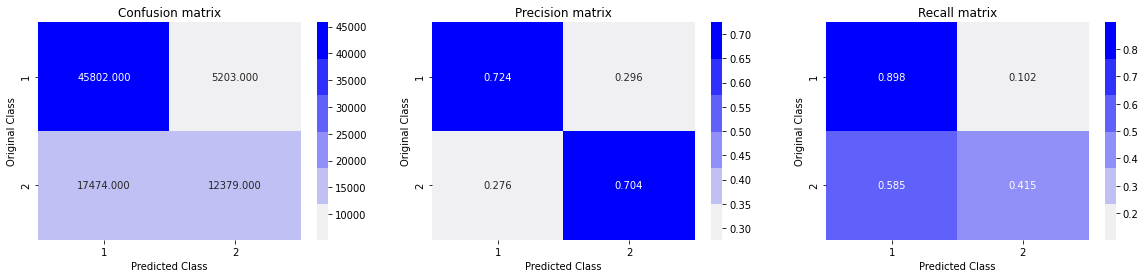

In [82]:
best_alpha = np.argmin(log_error_array_SVM)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)

predict_y = sig_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Boosting Algorithm ( Gradient Boosting )

In [83]:
params = {      
    'max_depth': [3, 4, 5, 6, 7, 8],       
    'eta' : [0.01, 0.02, 0.05, 0.1]    
}

lightxgb = lxgb.LGBMClassifier(boosting_type='gbdt', class_weight='balanced')
random_search = RandomizedSearchCV(lightxgb, param_distributions=params, scoring='neg_log_loss',return_train_score=True,cv=3) 
final_random=random_search.fit(x_train, y_train)

print("best parameters from randomsearch :",final_random.best_params_)

print("best score from randomsearch :",final_random.best_score_)

best parameters from randomsearch : {'max_depth': 8, 'eta': 0.01}
best score from randomsearch : -0.35028336067904203


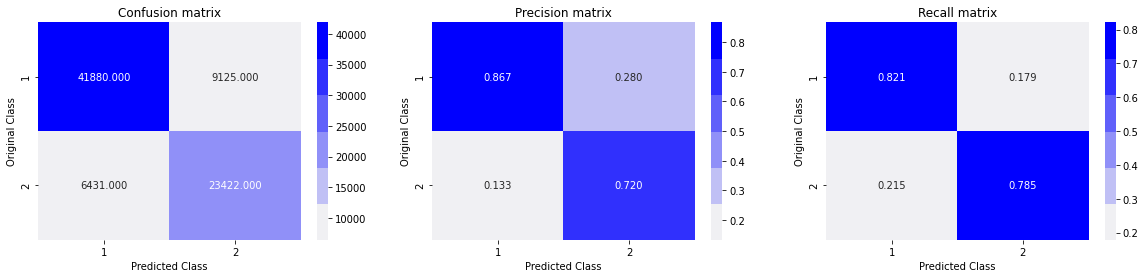

In [84]:
optimal_xgb = lxgb.LGBMClassifier(boosting_type='gbdt',ets=0.01, max_depth= 8, class_weight='balanced')

optimal_xgb.fit(x_train,y_train)
predicted_y= optimal_xgb.predict(x_test)
plot_confusion_matrix(y_test,predicted_y)